# Rank-Sum Test

This notebook walksthrough an example of a Rank-Sum test,
which is also called the Mann-Whitney U test.
The name used in `scipy` is `mannwhitneyu`.

In this notebook, we will pull a dataset containing gpa, iq, gender, and a test score for 390 students.
We will test for a difference in the location of the distribution of IQ for the students that scored above the 90th percentile (top 10% of teh scores) and the students that score in the 10th percentile (bottom 10% of the scores).
The label `concept` in the data corresponds to the test score.

In [1]:
import os
import requests

# package for reading rda files
import pyreadr

import numpy as np
import pandas as pd
from scipy.stats import norm
from scipy.stats import mannwhitneyu
import statsmodels.api as sm
import matplotlib.pyplot as plt


In [2]:
# download and unpack the data
data_file = "iq.rda"
if not os.path.exists(data_file):
    r = requests.get("https://github.com/OpenIntroStat/openintro/raw/master/data/gpa_iq.rda")
    with open(data_file, 'wb') as f:
        f.write(r.content)
data = pyreadr.read_r('iq.rda')
data = data["gpa_iq"]

In [3]:
data.head()

,obs,gpa,iq,gender,concept
0,1,7.940,111,2,67
1,2,8.292,107,2,43
2,3,4.643,100,2,52
3,4,7.470,107,2,66
4,5,8.882,114,1,58


In [24]:
data.size

390

We want to look at the difference in IQ of students who scored in the top 10 percent (90th percentile and above) and in the bottom 10 percent (10th percentile and below) of the group.

In [4]:
lower_bound, upper_bound = np.percentile(data.concept.values, [10, 90], method='closest_observation')

higher_score_iqs = data[data.concept >= upper_bound].iq
higher_score_iqs_mean = np.mean(higher_score_iqs)

lower_score_iqs = data[data.concept <= lower_bound].iq
lower_score_iqs_mean = np.mean(lower_score_iqs)

print(f"The lower 10% score is {lower_bound} and the upper 10% score is {upper_bound}")
print(f"The mean lower 10% score is {lower_score_iqs_mean} and the mean upper 10% score is {higher_score_iqs_mean:0.1f}")

The lower 10% score is 39 and the upper 10% score is 70
The mean lower 10% score is 97.0 and the mean upper 10% score is 118.3


The plot below shows the distribution of scores for the students in the top 10%
and the distribution of scores for the student in the bottom 10%.

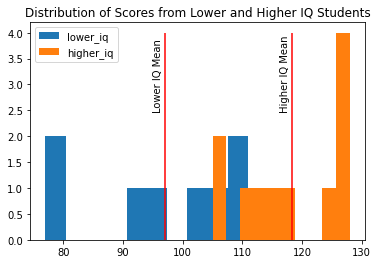

In [5]:
plt.hist(lower_score_iqs, label='lower_iq')
plt.vlines(lower_score_iqs_mean, 0, 4, colors='red')
plt.text(lower_score_iqs_mean - 2, 2.5,'Lower IQ Mean',rotation=90)
plt.hist(higher_score_iqs, label='higher_iq')
plt.vlines(higher_score_iqs_mean, 0, 4, colors='red')
plt.text(higher_score_iqs_mean - 2, 2.5,'Higher IQ Mean',rotation=90)
plt.legend()
plt.title("Distribution of Scores from Lower and Higher IQ Students");

## Check Assumptions

Recall for the t-test there are 3 assumptions

1. The datasets are normally distributed
2. The datasets have equal variance (though we can use Welch's t-test with unequal variances)
3. The samples are independent

For the purposes of this exercise,
we will assume the assumption of independence is met,
but keep in mind that we do not know how this data was sampled.
We will check the other two assumptions in the cells below.

### Normality

Based on the plots below,
the datasets do NOT appear to be normally distributed.

/var/folders/x7/_cy_rqsj03111rr15vx6_jh80000gn/T/ipykernel_32165/2889662839.py:5: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show();


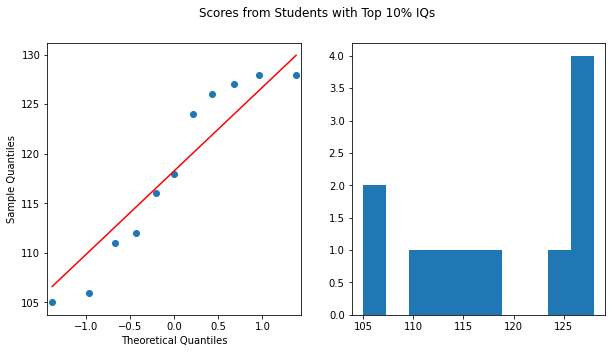

In [6]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
sm.qqplot(higher_score_iqs, line='s', ax=ax[0])
ax[1].hist(higher_score_iqs)
fig.suptitle("Scores from Students with Top 10% IQs")
fig.show();

/var/folders/x7/_cy_rqsj03111rr15vx6_jh80000gn/T/ipykernel_32165/354991212.py:5: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show();


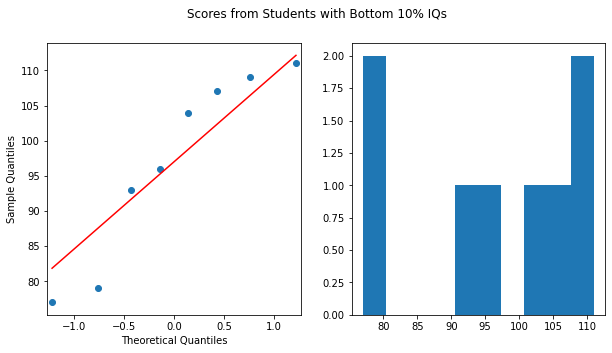

In [7]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
sm.qqplot(lower_score_iqs, line='s', ax=ax[0])
ax[1].hist(lower_score_iqs)
fig.suptitle("Scores from Students with Bottom 10% IQs")
fig.show();

### Equal Variances

The plot below shows the distribution of each group.
Based on the plot, the groups appear to have different variances.

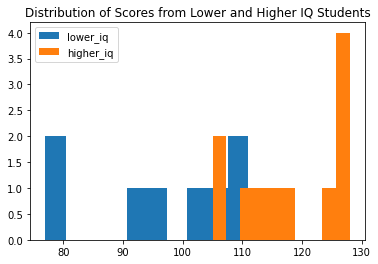

In [8]:
plt.hist(lower_score_iqs, label='lower_iq')
plt.hist(higher_score_iqs, label='higher_iq')
plt.legend()
plt.title("Distribution of Scores from Lower and Higher IQ Students");

The assessment showed that both the assumption of normality
and the assumption of equal variances appear to be violated.

When the assumptions of the t-test are violated, the results will be invalid.
As discussed a nonparametric alterative test is the Rank-Sum test.

The Rank-Sum test is 

In [9]:
higher_score_iqs

6     111
25    128
26    128
32    124
36    106
37    118
41    126
42    116
43    127
65    105
74    112
Name: iq, dtype: int32

In [10]:
lower_score_iqs

10    104
21    109
31    111
57     79
67    107
69     77
72     96
76     93
Name: iq, dtype: int32

In [11]:
mannwhitneyu(higher_score_iqs, lower_score_iqs).pvalue

0.00222925216588146

## Signed Rank Test Manually

In [12]:
# label L group with 0 and H group with 1
group_labels = np.concatenate([np.zeros_like(lower_score_iqs), np.ones_like(higher_score_iqs)])
# combine all samples
all_samples = np.concatenate([lower_score_iqs, higher_score_iqs])

In [13]:
# create dataframe from samples and group labels
df = pd.DataFrame(
    {
        'samples' : all_samples,
        'group' : group_labels,
    }
)
# sort records by sample value
df = df.sort_values('samples').reset_index(drop=True)
# rank values from 1
df['raw_rank'] = df.index.values + 1
# correct ranks where ties occur
df['rank_'] = df.samples.apply(lambda x: df[df.samples==x].raw_rank.mean() if df.samples.value_counts().loc[x] > 1 else df[df.samples==x].raw_rank.iloc[0])

In [14]:
df.head()

,samples,group,raw_rank,rank_
0,77,0,1,1.0
1,79,0,2,2.0
2,93,0,3,3.0
3,96,0,4,4.0
4,104,0,5,5.0


In [15]:
# get the test statistic
T = df[df.group==0].rank_.sum()
print(T)

42.5


In [16]:
# get term Mean(T)
mean_T = df.rank_.mean() * df[df.group==0].rank_.size
mean_T

80.0

In [18]:
# get term STDEV(T)
def pooled_size(n1, n2):
    return np.sqrt(n1 * n2 / (n1 + n2))

ps = pooled_size(df[df.group==0].rank_.size, df[df.group==1].rank_.size)

sd_T = df.rank_.std() * ps
sd_T

12.099973418365273

In [19]:
# get approx Z
Z = (T - mean_T)/sd_T
Z

-3.099180362089284

In [23]:
# get p-value
norm.cdf(Z) * 2

0.0019405684525695872